In [ ]:
# General imports
import numpy as np
import pandas as pd
import pickle

# Machine learning and metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# TensorFlow for LSTM model
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError

Load Models

In [ ]:
# Load SARIMAX model
with open("/content/sarimax_model.pkl", "rb") as f:
    sarimax_model = pickle.load(f)

# Load XGBoost model
with open("/content/trained_model_xg.pkl", "rb") as f:
    xgboost_model = pickle.load(f)

# Define 'mse' as a known custom object
custom_objects = {'mse': MeanSquaredError()}

# Load the model with custom objects
lstm_model = load_model("/content/lstm_model.h5", custom_objects=custom_objects)


Load and Prepare Data

In [ ]:
# Load the cleaned dataset
df_cleaned = pd.read_excel("/content/Cleaned_dataset.xlsx")




  settlement_date  settlement_period     nd      tsd  england_wales_demand  \
0      2009-01-01                  1  37910  38704.0                 33939   
1      2009-01-01                  2  38047  38964.0                 34072   
2      2009-01-01                  3  37380  38651.0                 33615   
3      2009-01-01                  4  36426  37775.0                 32526   
4      2009-01-01                  5  35687  37298.0                 31877   

   embedded_wind_generation  embedded_wind_capacity  \
0                        54                    1403   
1                        53                    1403   
2                        53                    1403   
3                        50                    1403   
4                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
0                          0                        0            0  ...   
1                          0                      

In [ ]:
# Confirm the data is loaded
print(df_cleaned.head(5))

  settlement_date  settlement_period     nd      tsd  england_wales_demand  \
0      2009-01-01                  1  37910  38704.0                 33939   
1      2009-01-01                  2  38047  38964.0                 34072   
2      2009-01-01                  3  37380  38651.0                 33615   
3      2009-01-01                  4  36426  37775.0                 32526   
4      2009-01-01                  5  35687  37298.0                 31877   

   embedded_wind_generation  embedded_wind_capacity  \
0                        54                    1403   
1                        53                    1403   
2                        53                    1403   
3                        50                    1403   
4                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  non_bm_stor  ...  \
0                          0                        0            0  ...   
1                          0                      

In [ ]:
# Example data (replace with your actual dataset)
# Ensure 'settlement_date' is the index
df_cleaned['settlement_date'] = pd.to_datetime(df_cleaned['settlement_date'])
df_cleaned.set_index('settlement_date', inplace=True)

features = ["Imp_Exp_flow", "renewable_generation"]
target = "tsd"

# Normalize data for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_cleaned[features + [target]])
data_scaled = pd.DataFrame(data_scaled, columns=features + [target], index=df_cleaned.index)

# Train-test split
train_size = int(len(data_scaled) * 0.8)
train, test = data_scaled[:train_size], data_scaled[train_size:]


 Make Predictions

Align Test Data with Model Features

In [ ]:
# Retrieve the expected features for the XGBoost model
expected_features = xgboost_model.feature_names_in_
print("Expected features:", expected_features)

# Create all necessary features in the test DataFrame
test.loc[:, 'lag1'] = test[target].shift(1)
test.loc[:, 'lag2'] = test[target].shift(2)
test.loc[:, 'lag3'] = test[target].shift(3)

test.loc[:, 'day_of_week'] = test.index.dayofweek
test.loc[:, 'day_of_month'] = test.index.day
test.loc[:, 'week_of_year'] = test.index.isocalendar().week
test.loc[:, 'month'] = test.index.month
test.loc[:, 'year'] = test.index.year
test.loc[:, 'is_holiday'] = 0  # Example: Set default if no holiday info is available
test.loc[:, 'day_of_year'] = test.index.dayofyear
test.loc[:, 'quarter'] = test.index.quarter

# Select only the columns the model expects
test_features = test[expected_features]



Expected features: ['Imp_Exp_flow' 'renewable_generation' 'is_holiday' 'day_of_month'
 'day_of_week' 'day_of_year' 'quarter' 'month' 'year' 'week_of_year'
 'lag1' 'lag2' 'lag3']


<ipython-input-12-1a2e5aa2cf03>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'is_holiday'] = 0  # Example: Set default if no holiday info is available
<ipython-input-12-1a2e5aa2cf03>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'day_of_year'] = test.index.dayofyear
<ipython-input-12-1a2e5aa2cf03>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [ ]:
# SARIMAX Predictions
sarimax_preds = sarimax_model.get_forecast(steps=len(test)).predicted_mean

# Make predictions using the XGBoost model
xgboost_preds = xgboost_model.predict(test_features)

print("XGBoost Predictions:", xgboost_preds)

# LSTM Predictions
def create_sequences(data, sequence_length=48):
    X = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
    return np.array(X)

sequence_length = 48
X_lstm = create_sequences(test[features].values, sequence_length)
lstm_preds = lstm_model.predict(X_lstm)

# Align LSTM predictions with SARIMAX and XGBoost
lstm_preds = lstm_preds.flatten()[-len(sarimax_preds):]  # Adjust LSTM output length


XGBoost Predictions: [54745.188 18165.895 18410.559 ... 19114.875 19114.875 19114.875]
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step


Combine Predictions and Train Meta-Model

In [ ]:
print(f"SARIMAX predictions shape: {sarimax_preds.shape}")
print(f"XGBoost predictions shape: {xgboost_preds.shape}")
print(f"LSTM predictions shape: {lstm_preds.shape}")


SARIMAX predictions shape: (55040,)
XGBoost predictions shape: (55040,)
LSTM predictions shape: (54992,)


In [ ]:
min_length = min(len(sarimax_preds), len(xgboost_preds), len(lstm_preds))

# Trim predictions to the minimum length
sarimax_preds = sarimax_preds[:min_length]
xgboost_preds = xgboost_preds[:min_length]
lstm_preds = lstm_preds[:min_length]

# Trim the target variable as well
stacked_target = test[target].values[:min_length]


In [ ]:
stacked_features = np.vstack([sarimax_preds, xgboost_preds, lstm_preds]).T


In [ ]:
# Prepare training data for stacking
stacked_features = np.vstack([sarimax_preds, xgboost_preds, lstm_preds]).T
stacked_target = test[target].values[:len(stacked_features)]  # Align with predictions

# Train-test split for meta-model
X_train_stack, X_test_stack, y_train_stack, y_test_stack = train_test_split(
    stacked_features, stacked_target, test_size=0.2, random_state=42
)

# Train meta-model
meta_model = LinearRegression()
meta_model.fit(X_train_stack, y_train_stack)

# Meta-model predictions
meta_preds = meta_model.predict(X_test_stack)


 Evaluate and Visualize

MAE: 0.0648008005934655
MAPE: 32.08%
RMSE: 0.0832907914164817


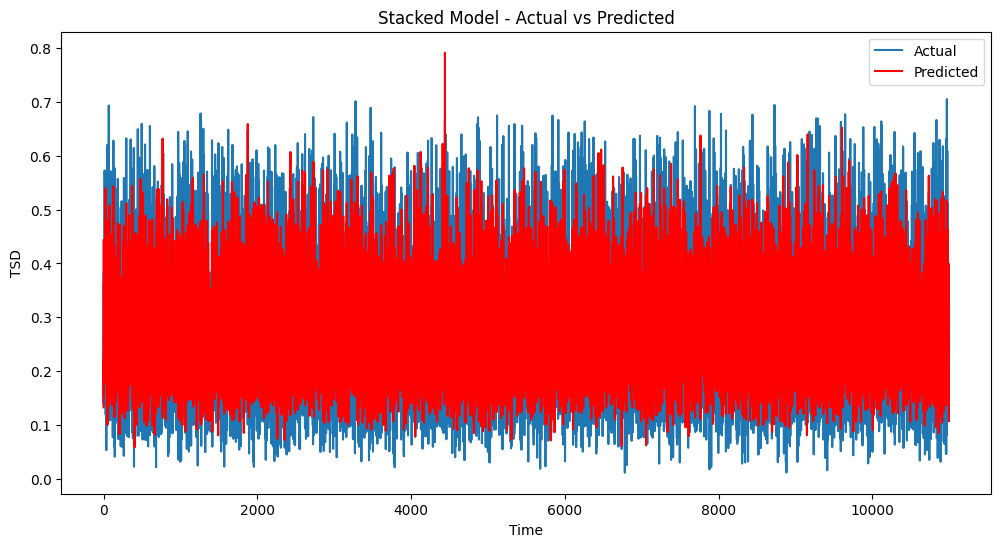

In [ ]:
# Evaluation Metrics
mae = mean_absolute_error(y_test_stack, meta_preds)
mape = mean_absolute_percentage_error(y_test_stack, meta_preds)
rmse = np.sqrt(mean_squared_error(y_test_stack, meta_preds))

print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

# Visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_stack, label="Actual")
plt.plot(meta_preds, label="Predicted", color="red")
plt.title("Stacked Model - Actual vs Predicted")
plt.xlabel("Time")
plt.ylabel("TSD")
plt.legend()
plt.show()
